# 뉴스 카테고리 다중분류

## 프로젝트 개요
텐서플로 데이터셋 중 하나인 '로이터 뉴스 주제 분류'에 대한 머신러닝 분류 모델을 구축하고 테스트합니다.

## 코드 구성
코드는 크게 세 부분으로 나뉩니다.

- 데이터 전처리 (함수)
로이터 뉴스 데이터에 대해서, 텍스트를 딕셔너리로 바꾸고, 딕셔너리를 다시 디코딩하는 기능을 갖춘 함수입니다.

- 모델 구축 (함수)


- 모델 실행결과 저장 및 시각화

In [ ]:
import numpy as np
from tensorflow.keras.datasets import reuters
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# 데이터 전처리 함수
def preprocess_data(num_words=None):
    # 데이터 로드
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)

    # 클래스 개수 계산
    num_classes = max(y_train) + 1

    # 단어 인덱스 가져오기
    word_index = reuters.get_word_index(path="reuters_word_index.json")

    # 인덱스를 단어로 변환하는 딕셔너리 생성 (+3은 특수 토큰 고려)
    index_to_word = { index+3: word for word, index in word_index.items() }
    # 특수 토큰 추가
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
        index_to_word[index] = token

    # 데이터를 텍스트로 디코딩하는 내부 함수
    def decode_text(encoded_data):
        return [' '.join([index_to_word.get(index, '?') for index in sequence]) for sequence in encoded_data]

    # 훈련 데이터와 테스트 데이터 디코딩
    decoded_x_train = decode_text(x_train)
    decoded_x_test = decode_text(x_test)

    return decoded_x_train, y_train, decoded_x_test, y_test, num_classes

In [ ]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# 모델별 설정 함수
def set_model_and_params_naive_bayes():
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])
    params = {
        'clf__alpha': [0.1, 1.0, 10.0],
    }
    return model, params

def set_model_and_params_cnb():
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', ComplementNB()),
    ])
    params = {
        'clf__alpha': [0.1, 1.0, 10.0],
    }
    return model, params

# Logistic Regression 설정 함수
def set_model_and_params_logistic_regression():
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(max_iter=1000)),  # max_iter 값을 증가
    ])
    params = {
        'clf__C': [0.1, 1.0, 10.0],
        'clf__penalty': ['l2'],
    }
    return model, params

# SVM 설정 함수
def set_model_and_params_svm():
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC()),
    ])
    params = {
        'clf__C': [0.1, 1.0, 10.0],
        'clf__kernel': ['linear', 'rbf'],
    }
    return model, params

# Decision Tree 설정 함수
def set_model_and_params_decision_tree():
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', DecisionTreeClassifier()),
    ])
    params = {
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
    }
    return model, params

# Random Forest 설정 함수
def set_model_and_params_random_forest():
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier()),
    ])
    params = {
        'clf__n_estimators': [10, 100, 200],
        'clf__max_depth': [None, 10, 20, 30],
    }
    return model, params

# Gradient Boosting 설정 함수
def set_model_and_params_gradient_boosting():
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', GradientBoostingClassifier(subsample=0.8)),  # subsample 추가
    ])
    params = {
        'clf__n_estimators': [50, 100],  # n_estimators 줄이기
        'clf__learning_rate': [0.1, 0.2],  # learning_rate 조정
        'clf__max_depth': [3, 4],  # max_depth 줄이기
        'clf__n_iter_no_change': [5],  # 조기 중단 설정
        'clf__tol': [1e-3],  # 조기 중단을 위한 허용 오차 설정
    }
    return model, params


In [ ]:
import time

# 그리드 서치 실행 및 결과 저장 함수
def run_grid_search(model, params, x_train, y_train, x_test, y_test):
    start_time = time.time()  # 시작 시간 기록
    grid_search = GridSearchCV(model, params, n_jobs=-1, cv=5)
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
    test_score = best_model.score(x_test, y_test)
    end_time = time.time()  # 종료 시간 기록
    elapsed_time = end_time - start_time  # 경과 시간 계산
    return {
        'best_params': grid_search.best_params_,
        'test_score': test_score,
        'elapsed_time': elapsed_time  # 경과 시간 추가
    }

# 모델별 실행 및 결과 저장하는 함수
def run_model_with_different_num_words(model_func, model_name):
    for num_words in [10000, 5000, None]:  # None은 전체 vocab을 사용한다는 의미입니다.
        print(f"\nTraining {model_name} with num_words={num_words}")
        x_train, y_train, x_test, y_test, num_classes = preprocess_data(num_words)
        model, params = model_func()
        result_key = f"{model_name}_num_words_{num_words if num_words is not None else 'all'}"
        all_results[result_key] = run_grid_search(model, params, x_train, y_train, x_test, y_test)

In [ ]:
# 모델별 결과를 저장할 딕셔너리
all_results = {}

# 모델별로 함수를 실행합니다.
run_model_with_different_num_words(set_model_and_params_naive_bayes, 'naive_bayes')


Training naive_bayes with num_words=10000

Training naive_bayes with num_words=5000

Training naive_bayes with num_words=None

Training cnb with num_words=10000

Training cnb with num_words=5000

Training cnb with num_words=None

Training logistic_regression with num_words=10000

Training logistic_regression with num_words=5000

Training logistic_regression with num_words=None

Training svm with num_words=10000

Training svm with num_words=5000

Training svm with num_words=None

Training decision_tree with num_words=10000

Training decision_tree with num_words=5000

Training decision_tree with num_words=None

Training random_forest with num_words=10000


/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Training random_forest with num_words=5000

Training random_forest with num_words=None


/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Training gradient_boosting with num_words=10000


KeyboardInterrupt: 

In [ ]:
run_model_with_different_num_words(set_model_and_params_cnb, 'cnb')

In [ ]:
run_model_with_different_num_words(set_model_and_params_logistic_regression, 'logistic_regression')

In [ ]:
run_model_with_different_num_words(set_model_and_params_svm, 'svm')

In [ ]:
run_model_with_different_num_words(set_model_and_params_decision_tree, 'decision_tree')

In [ ]:
run_model_with_different_num_words(set_model_and_params_random_forest, 'random_forest')

In [ ]:
run_model_with_different_num_words(set_model_and_params_gradient_boosting, 'gradient_boosting')


Training gradient_boosting with num_words=10000

Training gradient_boosting with num_words=5000

Training gradient_boosting with num_words=None


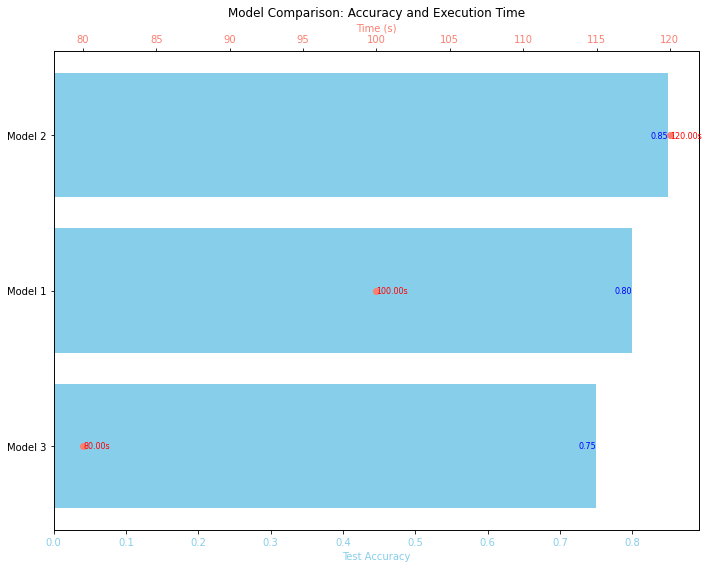

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 결과 시각화 함수 (수정)
def plot_results(results):
    # 결과를 정렬하여 표시합니다.
    sorted_labels = sorted(results.keys(), key=lambda x: (results[x]['test_score'], results[x]['elapsed_time']), reverse=True)

    # Test Accuracy와 실행 시간을 분리하여 리스트로 만듭니다.
    labels = []
    test_scores = []
    times = []
    for label in sorted_labels:
        labels.append(label.replace('_', ' ').title())  # 레이블을 보기 좋게 처리합니다.
        test_scores.append(results[label]['test_score'])
        times.append(results[label]['elapsed_time'])

    # 그래프 사이즈를 조정합니다.
    fig, ax1 = plt.subplots(figsize=(10, 8))

    # Test Accuracy 막대 그래프를 그립니다.
    y_positions = np.arange(len(labels))
    bars = ax1.barh(y_positions, test_scores, color='skyblue', label='Test Accuracy')
    ax1.set_yticks(y_positions)
    ax1.set_yticklabels(labels)
    ax1.invert_yaxis()  # 레이블을 높은 정확도가 위로 오도록 뒤집습니다.
    ax1.set_xlabel('Test Accuracy', color='skyblue')
    ax1.tick_params(axis='x', labelcolor='skyblue')

    # 막대 그래프에 정확도 값을 표시합니다.
    for bar, score in zip(bars, test_scores):
        ax1.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
                 '{0:.2f}'.format(score),
                 va='center', ha='right', color='blue', fontsize=8)

    # 실행 시간 라인 그래프를 그립니다.
    ax2 = ax1.twiny()  # x 축을 공유하는 새 축을 생성합니다.
    points = ax2.plot(times, y_positions, 'o', color='salmon', label='Time (s)')
    ax2.set_xlabel('Time (s)', color='salmon')
    ax2.tick_params(axis='x', labelcolor='salmon')

    # 라인 그래프에 실행 시간 값을 표시합니다.
    for time, pos in zip(times, y_positions):
        ax2.text(time, pos, '{0:.2f}s'.format(time),
                 va='center', ha='left', color='red', fontsize=8)

    plt.title('Model Comparison: Accuracy and Execution Time')
    fig.tight_layout()  # 그래프 레이아웃을 조정합니다.
    plt.show()

# 예시 데이터로 함수를 실행해보겠습니다.
results = {
    'model_1': {'test_score': 0.80, 'elapsed_time': 100},
    'model_2': {'test_score': 0.85, 'elapsed_time': 120},
    'model_3': {'test_score': 0.75, 'elapsed_time': 80},
}
plot_results(results)


In [ ]:
all_results

{'naive_bayes_num_words_10000': {'best_params': {'clf__alpha': 0.1},
  'test_score': 0.7506678539626002,
  'elapsed_time': 8.268959999084473},
 'naive_bayes_num_words_5000': {'best_params': {'clf__alpha': 0.1},
  'test_score': 0.7671415850400712,
  'elapsed_time': 7.058648347854614},
 'naive_bayes_num_words_all': {'best_params': {'clf__alpha': 0.1},
  'test_score': 0.709706144256456,
  'elapsed_time': 8.310611248016357},
 'cnb_num_words_10000': {'best_params': {'clf__alpha': 1.0},
  'test_score': 0.7707034728406055,
  'elapsed_time': 7.547343969345093},
 'cnb_num_words_5000': {'best_params': {'clf__alpha': 1.0},
  'test_score': 0.7707034728406055,
  'elapsed_time': 7.440619230270386},
 'cnb_num_words_all': {'best_params': {'clf__alpha': 0.1},
  'test_score': 0.7751558325912734,
  'elapsed_time': 8.254445314407349},
 'logistic_regression_num_words_10000': {'best_params': {'clf__C': 10.0,
   'clf__penalty': 'l2'},
  'test_score': 0.8178984861976848,
  'elapsed_time': 177.8671009540558},


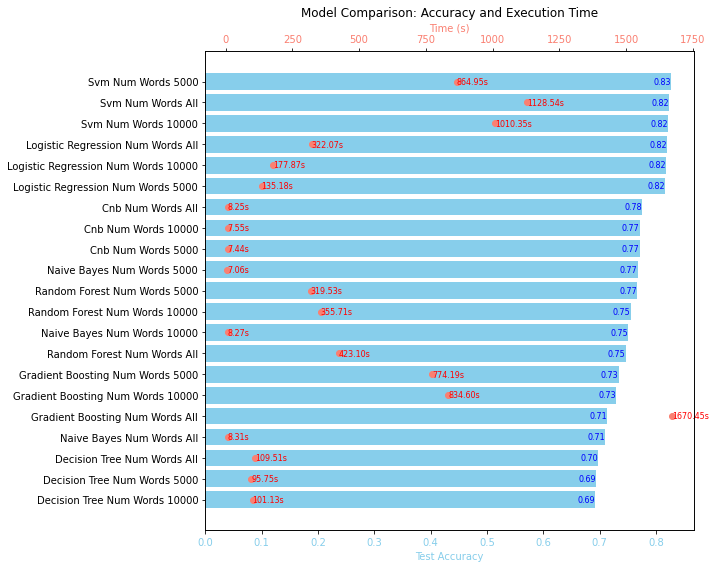

In [ ]:
# 모든 모델 실행 결과 시각화
plot_results(all_results)

# 딥러닝 모델과 비교 (케라스 순환신경망)

In [6]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터를 로드하고 전처리하는 함수
def load_data(num_words=10000, maxlen=500):
    # 로이터 뉴스 데이터셋 로드
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)

    # 데이터 패딩
    x_train = pad_sequences(x_train, maxlen=maxlen)
    x_test = pad_sequences(x_test, maxlen=maxlen)

    # 레이블 원-핫 인코딩
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return x_train, y_train, x_test, y_test

In [9]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import time

# 함수형 API를 사용하여 모델 정의
def build_rnn_model(input_shape, num_classes, units=64, dropout_rate=0.2, embed_dim=50, num_words=10000):
    inputs = Input(shape=input_shape)
    x = Embedding(num_words, embed_dim)(inputs)
    x = Bidirectional(LSTM(units, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(units, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(units))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 모델 훈련 함수
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test, batch_size=128, epochs=10):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    start_time = time.time()
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    return history, test_acc, elapsed_time


In [17]:
# 데이터 로드 및 전처리
x_train, y_train, x_test, y_test = load_data()

# 모델 생성
rnn_model = build_rnn_model((x_train.shape[1],), y_train.shape[1])

# 모델 훈련 및 평가
rnn_history, rnn_test_acc, rnn_elapsed_time = train_and_evaluate_model(
    rnn_model, x_train, y_train, x_test, y_test
)

Epoch 1/10
64/64 [==============================] - 37s 375ms/step - loss: 2.6925 - accuracy: 0.4356 - val_loss: 3.4242 - val_accuracy: 0.4060
Epoch 2/10
64/64 [==============================] - 17s 267ms/step - loss: 1.7571 - accuracy: 0.6126 - val_loss: 2.7360 - val_accuracy: 0.5039
Epoch 3/10
64/64 [==============================] - 18s 273ms/step - loss: 1.3828 - accuracy: 0.6913 - val_loss: 2.5170 - val_accuracy: 0.3838
Epoch 4/10
64/64 [==============================] - 15s 241ms/step - loss: 1.1056 - accuracy: 0.7455 - val_loss: 2.1595 - val_accuracy: 0.5039
Epoch 5/10
64/64 [==============================] - 16s 253ms/step - loss: 0.8808 - accuracy: 0.7939 - val_loss: 1.8285 - val_accuracy: 0.5584
Epoch 6/10
64/64 [==============================] - 16s 244ms/step - loss: 0.7093 - accuracy: 0.8348 - val_loss: 1.9651 - val_accuracy: 0.5439
Epoch 7/10
64/64 [==============================] - 16s 254ms/step - loss: 0.5647 - accuracy: 0.8635 - val_loss: 1.8160 - val_accuracy: 0.6218

In [12]:
# 기존 결과에 RNN 결과 추가
all_results['bi_lstm_rnn'] = {
    'test_score': rnn_test_acc,
    'elapsed_time': rnn_elapsed_time
}

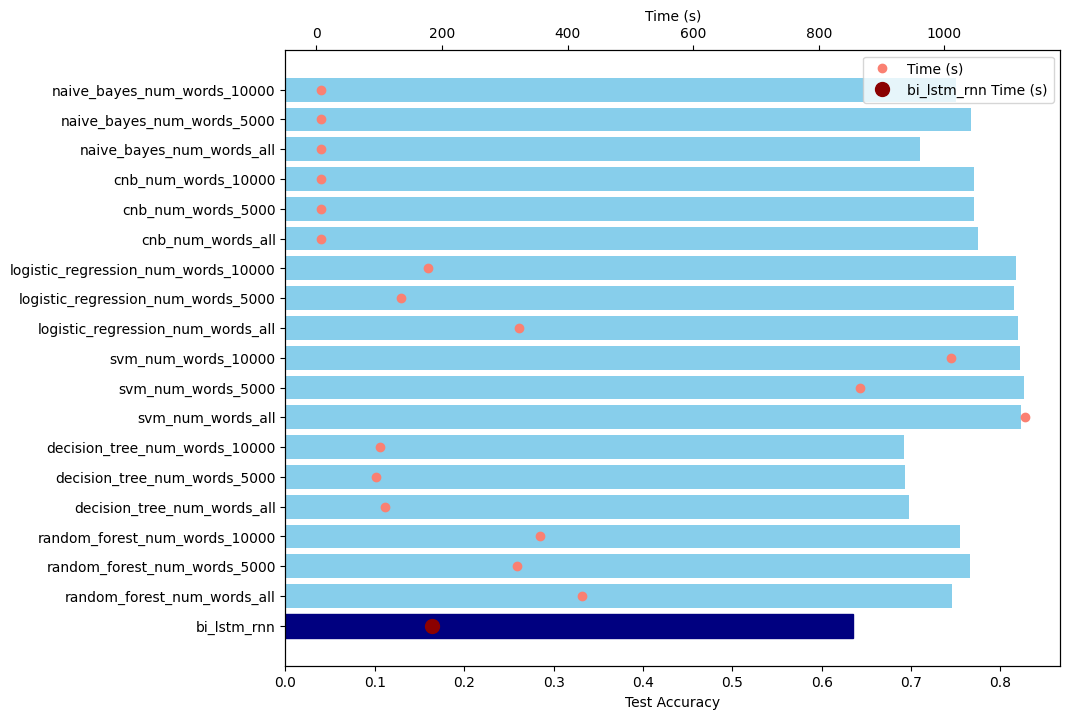

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 결과 시각화 함수
def plot_comparison(results):
    labels = list(results.keys())
    test_scores = [results[key]['test_score'] for key in labels]
    times = [results[key]['elapsed_time'] for key in labels]

    x = np.arange(len(labels))

    fig, ax1 = plt.subplots(figsize=(10, 8))

    # 다른 모델들의 정확도 막대 그래프
    bars = ax1.barh(x, test_scores, color='skyblue', label='Test Accuracy')
    # 'bi_lstm_rnn' 모델의 정확도 막대 그래프에 다른 색상 적용
    bars[labels.index('bi_lstm_rnn')].set_color('navy')

    ax1.set_xlabel('Test Accuracy')
    ax1.set_yticks(x)
    ax1.set_yticklabels(labels)
    ax1.invert_yaxis()

    ax2 = ax1.twiny()  # x 축을 공유하는 새 축을 생성
    # 다른 모델들의 시간 라인 그래프
    points = ax2.plot(times, x, 'o', color='salmon', label='Time (s)')
    # 'bi_lstm_rnn' 모델의 시간 라인 그래프에 다른 색상 적용
    ax2.plot(times[labels.index('bi_lstm_rnn')], x[labels.index('bi_lstm_rnn')], 'o', color='darkred', markersize=10, label='bi_lstm_rnn Time (s)')

    ax2.set_xlabel('Time (s)')

    plt.legend()
    plt.show()

# 모든 모델 실행 결과 시각화
plot_comparison(all_results)

# 회고

### 작업 주제와 결과를 통해 배운 것

딥러닝 중심으로 학습을 하면서 머신러닝에 대해서는 다소 모호하게 알고 있었는데, 이번 작업을 통해서 다양한 접근이 있다는 것을 어렴풋이나마 알게되어 좋았다.

무엇보다 기존 데이터의 절대량이나 하이퍼파라미터에 의해서 심층신경망의 성능이 달라진다는 자명한 사실을 다시한번 확인한 것도 좋았다. 딥러닝이 무조건 기존의 머신러닝보다 낫다고 할 수 없고, 결국 상황에 맞게 어떤 모델, 어떤 기술, 어떤 접근을 할 것인지 판단하는 것 혹은 그러한 판단에 관한 사전지식과 경험이 중요하다는 것을 배웠다.

### 작업 과정에서 느낀 점

초기 코드와 수정작업 대부분을 GPT에 위임해서 진행했다. 방대한 코드 전체를 이해하고 작성하는 것이 애초에 쉽진 않았지만, 방향성을 스스로 설정하고 프롬프트 명령을 작성할 수 있었기 때문에 문제가 생기더라도 빠르게 대응할 수 있었다.

아마 GPT가 없었다면 내가 할 수 있는 작업범위는 크게 제한되었을 것이다. 아니면 인터넷에서 찾을 수 있는 공개된 코드들을 가져다가 고치는 정도로 진행해야 완성을 시킬 수 있었을 거고.

이게 내가 공부하는 것이 맞나, 혹은 이렇게 GPT에 의존해서 성장할 수 있을까 의구심이 들다가도, 두달전 처음 아이펠 과정을 시작했던 나와 지금의 모습을 비교하면 모델을 설계하고 방향을 작업 방향을 GPT를 이용해서 빠르게 진행할 수 있다는 것 자체가 대단한 진전이라는 생각이 든다.

상당히 복잡한 코드를 쓰는 것은 몸을 쓰는 수고로운 일인데, 이 부분에 대한 생산성이 수백에서 수천 퍼센트 상승하고 있다.

사실 코드 작성 이외의 많은 분야에도 아이디어와 방향을 제외한 수고로운 부분이 많이 존재하지만, 코드 생성이 유리한 것은 수집할 수 있는 데이터가 다양한 기호/언어군의 다른 부문보다 온라인에서 수집하기가 훨씬 쉬운 까닭일 것이다.

혹은 코드도 일종의 자연어이지만, 궁극적으로 기계어를 거쳐 바이트 코드 수준에서 컴퓨터가 접근할 수 있도록 잘 추상화되어 있다는 점에서 일상적인 자연어와는 다른 점도 생성모델로 구현하기 유리한 점이 아닐까 싶다.

인간이 하는, 혹은 인간이 필요로 하는 다양한 언어적 / 기호적 작업들에 대해서 앞으로 많은 부분이 일상적으로 라벨링되거나, 가공되기 좋은 형태로 클라우드에 저장되는 기반이 마련될 것 같다. 이것을 촉진하는 한 단계로서 LLM을 각 영역에 접목하는 산업적 혁신이 당분간 지속될 것 같고 그 부분에서 무엇을 할 수 있을지 탐색해보고 싶다.